In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.losses import binary_crossentropy, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf

tf.config.list_physical_devices('GPU')

2023-03-07 19:19:46.396526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 19:19:47.821298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 19:19:47.834634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 19:19:47.834800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUM

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
data = np.load("mutations_coverage_prediction.npz")
max_len = 5000
X, Y = data['x'], data['y']
X = X.reshape((X.shape[0],X.shape[1]//40,40))
Y = Y.reshape((Y.shape[0],1))

train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1)
del X
del Y
del data

print ('Training:', train_x.shape, train_y.shape)
print ('Validation:', val_x.shape, val_y.shape)
print ('Test:', test_x.shape, test_y.shape)

Training: (72440, 125, 40) (72440, 1)
Validation: (8944, 125, 40) (8944, 1)
Test: (8049, 125, 40) (8049, 1)


In [3]:
# Base model
model = Sequential()
model.add(LSTM(512, input_shape=train_x[0].shape, return_sequences=True))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(1,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)))
model.summary()
adam = Adam(learning_rate=0.00005)
model.compile(optimizer=adam, loss=mean_squared_error)

2023-03-07 19:19:50.926899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 19:19:50.928743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 19:19:50.928908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 19:19:50.929037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125, 512)          1132544   
                                                                 
 dense (Dense)               (None, 125, 50)           25650     
                                                                 
 dense_1 (Dense)             (None, 125, 1)            51        
                                                                 
Total params: 1,158,245
Trainable params: 1,158,245
Non-trainable params: 0
_________________________________________________________________


In [4]:
es = EarlyStopping(monitor='val_loss', patience=5)

filepath = 'best_model_lstm_checkpoint.h5'

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

history = model.fit(train_x, train_y,
                    batch_size=32,
                    epochs=100,
                    validation_data=(val_x, val_y),
                    callbacks =[es, checkpoint])

Epoch 1/100


2023-03-07 19:19:53.606990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-07 19:19:53.689606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2261/2264 [============================>.] - ETA: 0s - loss: 10.0296
Epoch 1: val_loss improved from inf to 8.28299, saving model to best_model_lstm_checkpoint.h5
2264/2264 [==============================] - 20s 8ms/step - loss: 10.0256 - val_loss: 8.2830
Epoch 2/100
2263/2264 [============================>.] - ETA: 0s - loss: 8.0842
Epoch 2: val_loss improved from 8.28299 to 7.86959, saving model to best_model_lstm_checkpoint.h5
2264/2264 [==============================] - 17s 8ms/step - loss: 8.0829 - val_loss: 7.8696
Epoch 3/100
2257/2264 [============================>.] - ETA: 0s - loss: 7.7976
Epoch 3: val_loss improved from 7.86959 to 7.75316, saving model to best_model_lstm_checkpoint.h5
2264/2264 [==============================] - 17s 8ms/step - loss: 7.7986 - val_loss: 7.7532
Epoch 4/100
2258/2264 [============================>.] - ETA: 0s - loss: 7.6453
Epoch 4: val_loss improved from 7.75316 to 7.53648, saving model to best_model_lstm_checkpoint.h5
2264/2264 [===============

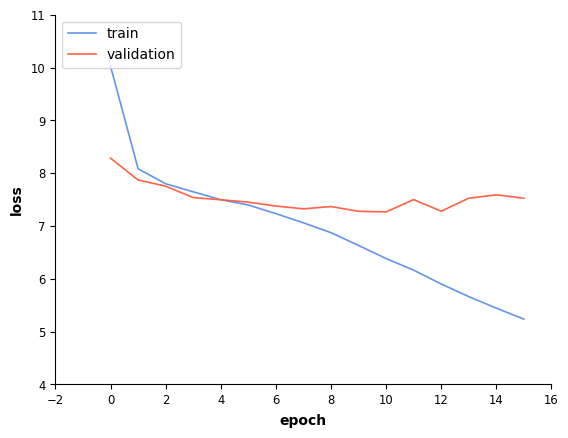

In [5]:
plt.style.use('apa')
# summarize history for loss
plt.plot(history.history['loss'], color='cornflowerblue',alpha=1)
plt.plot(history.history['val_loss'],color='tomato',alpha=1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [6]:
from keras.models import load_model
model = load_model("best_model_lstm_checkpoint.h5")
test_loss = model.evaluate(test_x, test_y)
test_loss

252/252 [==============================] - 1s 4ms/step - loss: 7.4740


7.47398042678833

In [7]:
test = np.array(test_x)
pred = [int(model.predict(test[i].reshape((1,) + test[i].shape)).flatten()[-1]//1) for i in range(len(test))]
pred = np.array(pred).flatten()
unique, counts = np.unique(pred, return_counts=True)


1/1 [==============================] - 0s 14ms/step


In [8]:
dict(zip(unique, counts))


{1: 11, 2: 721, 3: 889, 4: 1803, 5: 1060, 6: 756, 7: 1805, 8: 1004}

In [9]:
unique, counts = np.unique(pred - (test_y//np.max(test_y)*np.max(pred)), return_counts=True)
dict(zip(unique, counts))


{-7: 22,
 -6: 1442,
 -5: 1778,
 -4: 3606,
 -3: 2120,
 -2: 1512,
 -1: 3610,
 0: 2008,
 1: 88517,
 2: 5801887,
 3: 7153783,
 4: 14508741,
 5: 8529820,
 6: 6083532,
 7: 14524835,
 8: 8079188}

In [10]:
unique, counts = np.unique(pred, return_counts=True)
dict(zip(unique, counts))

{1: 11, 2: 721, 3: 889, 4: 1803, 5: 1060, 6: 756, 7: 1805, 8: 1004}